In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [20]:
def EA(series):
    
    # 设置aplha
#     alpha = 0.05
    
    # 设置半衰期
    h = 42
    alpha = 1 - np.exp(np.log(0.5)/h)
    
    seriesList = []
    seriesList.append(series[0])
    
    for i in range(1,len(series)):
        seriesList.append(seriesList[i-1]*(1-alpha)+series[i]*alpha)
        
    return seriesList[-1]

In [70]:
# 测试
Asset = pd.read_excel('C:/Users/Thinkpad/Desktop/原电脑桌面/大类资产数据.xlsx').set_index('date')
Asset['EMA沪深300'] = Asset['沪深300'].rolling(252).apply(EA,raw=True)

In [71]:
# 均线策略，信号计算
Asset['signal_tmp'] = (Asset['沪深300'] - Asset['EMA沪深300']).apply(lambda x: 1 if x>=0 else 0)
Asset = Asset.dropna().copy()
Asset['signal'] = Asset['signal_tmp'] - Asset['signal_tmp'].shift(1)

In [73]:
Asset['return'] = Asset['沪深300'].pct_change()
Asset = Asset.dropna().copy()

In [109]:
# 发出买入信号时的最大持仓仓位
TolPosition = 0.9
EquityList = [1]
DateList = []
# 现金+资产组合价值 构成 净值
Cash = 1
Portfolio = 0
for dateCnt in range(len(Asset.index)-1):
    
    date = Asset.index[dateCnt]
    date_next = Asset.index[dateCnt+1]
    
    signal = Asset.loc[date,'signal']
    return_asset = Asset.loc[date_next,'return']
    
    if signal == 1:
        Portfolio = Cash*TolPosition
        Cash = Cash*(1-TolPosition)
    if signal == -1:
        Cash = Cash + Portfolio
        Portfolio = 0
    # 结算
    Portfolio = Portfolio*(1+return_asset)
    Cash = Cash*(1+0.0002)
    
    Equity = Portfolio+Cash
    EquityList.append(Equity)
    DateList.append(date_next)

EquityDf = pd.DataFrame({'净值':EquityList,'date':Asset.index}).set_index('date')

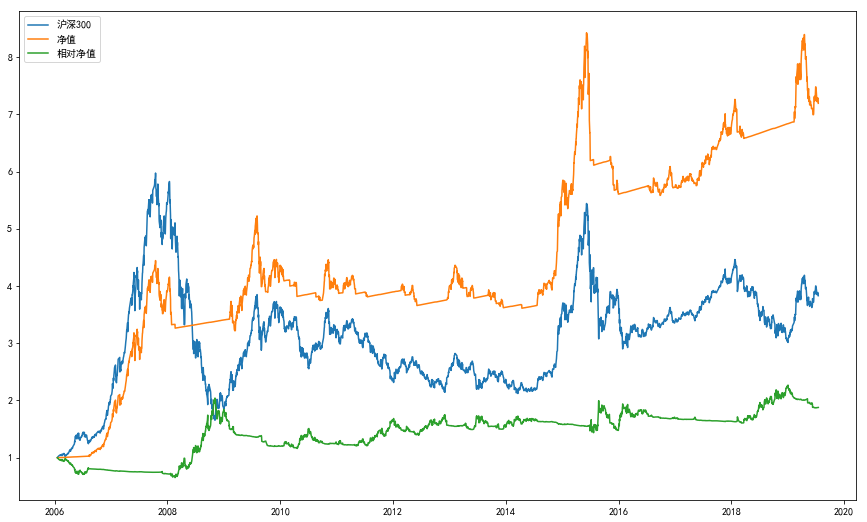

In [110]:
bench_mark_equity_series = Asset['沪深300']/Asset['沪深300'].tolist()[0]

plt.figure(figsize=(15,9))
plt.plot(bench_mark_equity_series,label='沪深300')
plt.plot(EquityDf['净值'],label='净值')
plt.plot(EquityDf['净值']/bench_mark_equity_series,label='相对净值')
plt.legend(loc=0)
plt.show()